# SIGN LANGUAGE MODEL USING MOBILENETV1

### IMPORT LIBRARIES

In [ ]:
# Standard libraries
import os
import random
import shutil
import warnings
import itertools

# Data processing and visualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image 

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Flatten, Lambda,
    GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNet

# Evaluation and metrics
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report,
    RocCurveDisplay, roc_curve, auc
)

### SPLIT DATASET INTO TRAIN, VALID, TEST

In [ ]:
# Change to your own path
dataset_path = "./DatasetHuruf/Mentahan"
train_path = "./DatasetHuruf/Train"
test_path = "./DatasetHuruf/Test"
val_path = "./DatasetHuruf/Valid"

os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        random.shuffle(images)  

        train_split = int(0.7 * len(images))  
        val_split = int(0.1 * len(images)) + train_split  

        train_images = images[:train_split]
        val_images = images[train_split:val_split]
        test_images = images[val_split:]  

        os.makedirs(os.path.join(train_path, class_folder), exist_ok=True)
        os.makedirs(os.path.join(val_path, class_folder), exist_ok=True)
        os.makedirs(os.path.join(test_path, class_folder), exist_ok=True)

        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_path, class_folder, img))

        for img in val_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(val_path, class_folder, img))

        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_path, class_folder, img))

print("Dataset telah dibagi ke dalam folder train, val, dan test.")



Dataset telah dibagi ke dalam folder train, val, dan test.


### DATA AUGMENTATION

In [ ]:

# Your own dataset path
train_path = './DatasetHuruf/Train' 
test_path = './DatasetHuruf/Test'

# Data generator for training with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.2, 1.2]
)

# Data generator for validation & test with spliting
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

# Load training data
train_batches = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

# Validation: 20% from test_path
valid_batches = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=46
)

# Testing: 80% from test_path
test_batches = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training',
    shuffle=False,
    seed=46
)

Found 3696 images belonging to 24 classes.
Found 192 images belonging to 24 classes.
Found 864 images belonging to 24 classes.


### IMPLEMENT MOBILENETV1 MODEL

In [ ]:
input_tensor = Input(shape=(224, 224, 3))

# Load MobileNet V1 without top layer
mobilenet_base = MobileNet(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Freeze all layes
for layer in mobilenet_base.layers:
    layer.trainable = False

# Unfreeze the layer from depthwise_Conv2d_11 to above to retrain
set_trainable = False
for layer in mobilenet_base.layers:
    if layer.name.startswith('conv_dw_11'):
        set_trainable = True
    if set_trainable:
        layer.trainable = True

# Add custom layer
x = GlobalAveragePooling2D()(mobilenet_base.output)
predictions = Dense(24, activation='softmax')(x)

# Make final model
mobilenet_model = Model(inputs=mobilenet_base.input, outputs=predictions)

In [5]:
mobilenet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,253,464 (12.41 MB)

 Trainable params: 1,887,256 (7.20 MB)

 Non-trainable params: 1,366,208 (5.21 MB)

In [6]:
mobilenet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = mobilenet_model.fit(
    train_batches,
    steps_per_epoch=58,          # total_data_train / batch_size
    validation_data=valid_batches,
    validation_steps=8,          # total_data_val / batch_size
    epochs=100,
    callbacks=[early_stopping]
)



Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.1198 - loss: 3.2002 - val_accuracy: 0.3021 - val_loss: 2.4238
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.4179 - loss: 2.0065 - val_accuracy: 0.7031 - val_loss: 1.1077
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 175s 3s/step - accuracy: 0.5532 - loss: 1.5986 - val_accuracy: 0.7917 - val_loss: 0.6704
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.5942 - loss: 1.4032 - val_accuracy: 0.8490 - val_loss: 0.4794
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - accuracy: 0.6484 - loss: 1.2404 - val_accuracy: 0.8854 - val_loss: 0.4102
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.6709 - loss: 1.1276 - val_accuracy: 0.9271 - val_loss: 0.3324
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.6641 - loss: 1.1466 - val_accuracy: 0.9271 - val_loss: 0.2597
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.6817 - loss: 1.0780 - val_accuracy: 0.

### MODEL RESULTS WITH PLOTTING

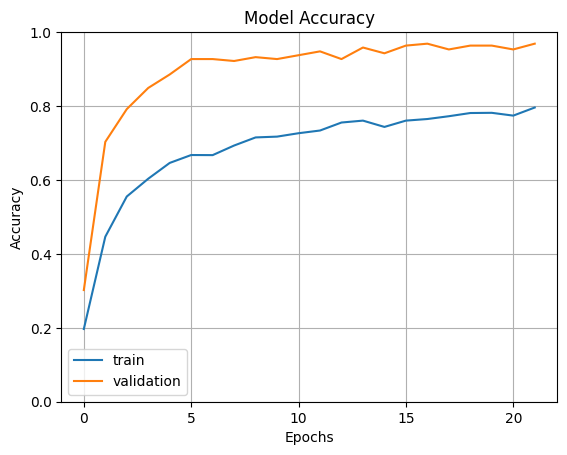

In [11]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

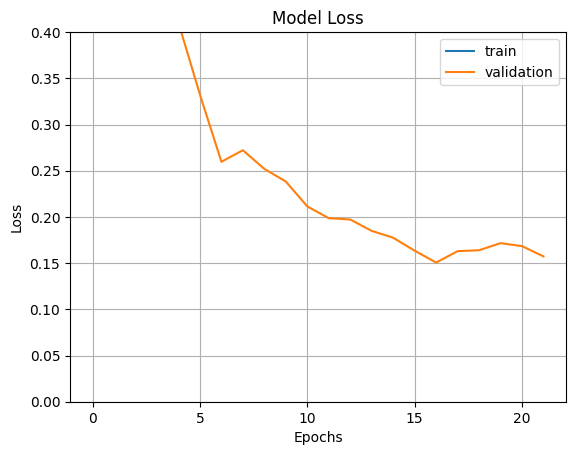

In [12]:
fig1 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0,ymax=0.4)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

### TESTING MODEL

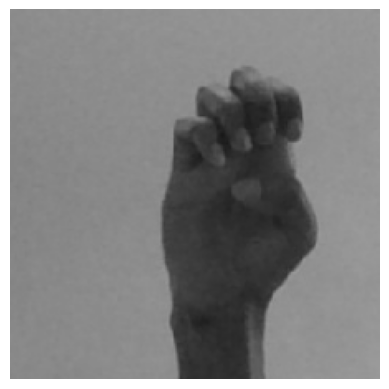

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted Class: E


In [ ]:

label_dict = {
    0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 6: "G", 7: "H", 8: "I", 9: "K",
    10: "L", 11: "M", 12: "N", 13: "O", 14: "P", 15: "Q", 16: "R", 17: "S",
    18: "T", 19: "U", 20: "V", 21: "W", 22: "X", 23: "Y"
}
# Load image
img = "./DatasetHuruf/Test/E/1645946625.685273_T.jpg"
img_test = image.load_img(img, target_size=(224, 224))
x = image.img_to_array(img_test)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) 

# Predict
plt.imshow(img_test)
plt.axis('off')
plt.show()

pred = mobilenet_model.predict(x)
label_index = np.argmax(pred)
predicted_class = label_dict[label_index]

print("Predicted Class:", predicted_class)

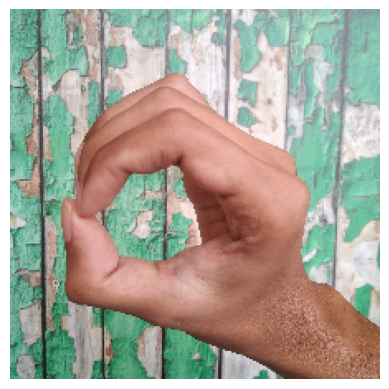

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Predicted Class: O


In [ ]:

label_dict = {
    0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 6: "G", 7: "H", 8: "I", 9: "K",
    10: "L", 11: "M", 12: "N", 13: "O", 14: "P", 15: "Q", 16: "R", 17: "S",
    18: "T", 19: "U", 20: "V", 21: "W", 22: "X", 23: "Y"
}

# Load image
img = "./DatasetHuruf/Test/O/IMG_20220221_112745.jpg"
img_test = image.load_img(img, target_size=(224, 224))
x = image.img_to_array(img_test)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) 

# Predict
plt.imshow(img_test)
plt.axis('off')
plt.show()

pred = mobilenet_model.predict(x)
label_index = np.argmax(pred)
predicted_class = label_dict[label_index]

print("Predicted Class:", predicted_class)

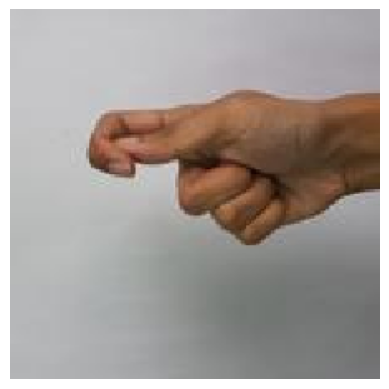

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
Predicted Class: R


In [ ]:

label_dict = {
    0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 6: "G", 7: "H", 8: "I", 9: "K",
    10: "L", 11: "M", 12: "N", 13: "O", 14: "P", 15: "Q", 16: "R", 17: "S",
    18: "T", 19: "U", 20: "V", 21: "W", 22: "X", 23: "Y"
}

# Load image
img_path = "./DatasetHuruf/Test/T/20201018_121643_009.jpg"
img_test = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img_test)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) 

# Predict
plt.imshow(img_test)
plt.axis('off')
plt.show()

pred = mobilenet_model.predict(x)
label_index = np.argmax(pred)
predicted_class = label_dict[label_index]

print("Predicted Class:", predicted_class)

### CONFUSION MATRIX

In [38]:
predictions = mobilenet_model.predict(test_batches, steps=len(test_batches), verbose=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step


In [ ]:

y_true = test_batches.classes  # label asli (ground truth)
y_pred = predictions.argmax(axis=1)  # hasil prediksi

cm = confusion_matrix(y_true, y_pred)

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[35  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0 35  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 35  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 34  0  0  0  0  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 34  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 36  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0 33  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 36  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  2  0  0 33  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1 29  0  0  0  0  2  0  0  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 36  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  1  0  0  0  1  0  0 29  4  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  4  0  0  0  0  0  0  2 30  0  0  0  0  0  0  

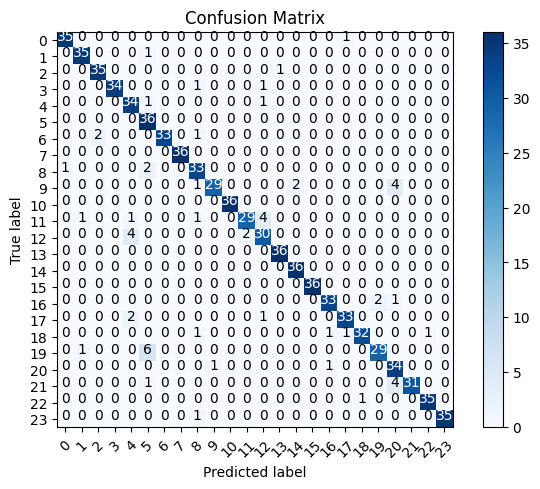

In [ ]:

cm_plot_lables = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9','10','11','12','13','14','15','16','17','18','19','20','21','22','23']
plot_confusion_matrix(cm, cm_plot_lables, title='Confusion Matrix')

### EVALUATION 

In [46]:
mobilenet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', precision, recall, f1]
)


In [58]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        36
           1       0.95      0.97      0.96        36
           2       0.95      0.97      0.96        36
           3       1.00      0.94      0.97        36
           4       0.83      0.94      0.88        36
           5       0.77      1.00      0.87        36
           6       1.00      0.92      0.96        36
           7       1.00      1.00      1.00        36
           8       0.85      0.92      0.88        36
           9       0.97      0.81      0.88        36
          10       1.00      1.00      1.00        36
          11       0.94      0.81      0.87        36
          12       0.81      0.83      0.82        36
          13       0.97      1.00      0.99        36
          14       0.95      1.00      0.97        36
          15       1.00      1.00      1.00        36
          16       0.94      0.92      0.93        36
          17       0.94    

### SAVE MODEL

In [60]:
mobilenet_model.save('mobile_net.h5')